In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('printer', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [5]:
# prepare data for clustering
df_half['weekofyear']=df_half.index.week
df_half['day_categ']=df_half.index.day_name()
df_half['day_num']=df_half.index.weekday
#df_half['day']=df_half.index.day
df_half['hour']=df_half.index.hour


# prepare day_type --> weekday, weekend, holiday
df_half['day_type'] = df_half['day_num'].apply(lambda x: 'weekday' if x <5 else 'weekend')
df_half.loc[(df_half.index >= '2019-12-24 00:00:00') & (df_half.index < '2019-12-26 00:00:00'), 'day_type']='holiday'
df_half.loc[(df_half.index >= '2020-01-01 00:00:00') & (df_half.index < '2020-01-02 00:00:00'), 'day_type']='holiday'

# prepare morning, afternoon, and night 
df_half['time_of_day'] =df_half['hour'].apply(lambda x: 'morning' if (x>=7) & (x<= 12) else ('afternoon' if (x>12) & (x<=18) else 'night'))

# lockdown
df_half.loc[(df_half.weekofyear >=12) & (df_half.weekofyear <24), 'day_type'] = 'holiday'


df_half['hour']=df_half.index.strftime('%H')

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [7]:
# subset data until lockdown 23/03/2020  (13 weeks * 7day * 48 points =4368)
subset = 4368
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [8]:
# split into train and test sets
train_size = int(len(train_test) * 0.7)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

3057 1311


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
look_back=48
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [11]:
# add extra variables day_type and time of the day

# extract the train variables for same length
df_train_var=df_half[['day_categ','time_of_day','day_type']][:len(trainX)]
# get dummies
df_dum_train=pd.get_dummies(df_train_var)

# extract the test variables for same length
df_test_var=df_half[['day_categ','time_of_day','day_type']][len(trainX):len(trainX)+len(testX)]
# get dummies
df_dum_test=pd.get_dummies(df_test_var)

# extract the validation variables for same length
df_simu_var=df_half[['day_categ','time_of_day','day_type']][len(trainX)+len(testX):len(trainX)+len(testX)+len(simuX)]
# get dummies
df_dum_simu=pd.get_dummies(df_simu_var)
df_dum_simu['day_type_weekday']=0
df_dum_simu['day_type_weekend']=0

In [12]:
#to np
np_train=np.array(df_dum_train)

#to np
np_test=np.array(df_dum_test)

#to np
np_simu=np.array(df_dum_simu)

In [13]:
#concatenate trainX, testX, validX with variables, respectively
trainX_ok = np.concatenate((trainX, np_train),axis=1)
testX_ok = np.concatenate((testX, np_test),axis=1)
simuX_ok = np.concatenate((simuX, np_simu),axis=1)

In [14]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(125, input_dim=look_back+13, activation='relu'))
model.add(Dense(60, activation='relu'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history = model.fit(trainX_ok, trainY, epochs=250, batch_size=10, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 1s - loss: 146.1723 - mse: 146.1723 - mae: 7.2412 - mape: 17.9730
Epoch 2/250
 - 0s - loss: 125.4122 - mse: 125.4123 - mae: 6.2577 - mape: 15.0944
Epoch 3/250
 - 1s - loss: 117.7777 - mse: 117.7776 - mae: 5.8098 - mape: 13.7137
Epoch 4/250
 - 0s - loss: 113.7400 - mse: 113.7401 - mae: 5.5681 - mape: 12.9898
Epoch 5/250
 - 1s - loss: 117.0034 - mse: 117.0034 - mae: 6.0573 - mape: 14.5528
Epoch 6/250
 - 0s - loss: 110.4380 - mse: 110.4380 - mae: 5.5414 - mape: 12.9184
Epoch 7/250
 - 0s - loss: 108.2941 - mse: 108.2941 - mae: 5.5301 - mape: 12.9192
Epoch 8/250
 - 1s - loss: 114.1494 - mse: 114.1494 - mae: 5.7585 - mape: 13.6435
Epoch 9/250
 - 1s - loss: 106.8280 - mse: 106.8280 - mae: 5.5209 - mape: 12.9664
Epoch 10/250
 - 1s - loss: 109.5091 - mse: 109.5091 - mae: 5.5827 - mape: 13.1001
Epoch 11/250
 - 1s - loss: 105.6782 - mse: 105.6782 - mae: 5.3710 - m

Epoch 97/250
 - 0s - loss: 58.2311 - mse: 58.2311 - mae: 3.9961 - mape: 9.2180
Epoch 98/250
 - 0s - loss: 60.5099 - mse: 60.5099 - mae: 4.0682 - mape: 9.4460
Epoch 99/250
 - 0s - loss: 55.9354 - mse: 55.9354 - mae: 3.9121 - mape: 9.1531
Epoch 100/250
 - 1s - loss: 53.8336 - mse: 53.8336 - mae: 3.9610 - mape: 9.3393
Epoch 101/250
 - 1s - loss: 54.3745 - mse: 54.3745 - mae: 3.8983 - mape: 9.1567
Epoch 102/250
 - 1s - loss: 55.0505 - mse: 55.0505 - mae: 4.0709 - mape: 9.7723
Epoch 103/250
 - 0s - loss: 53.8961 - mse: 53.8962 - mae: 3.8211 - mape: 8.8830
Epoch 104/250
 - 1s - loss: 53.1165 - mse: 53.1165 - mae: 3.8695 - mape: 9.1185
Epoch 105/250
 - 1s - loss: 53.0671 - mse: 53.0671 - mae: 3.8342 - mape: 9.0078
Epoch 106/250
 - 0s - loss: 52.4743 - mse: 52.4743 - mae: 3.8502 - mape: 8.9484
Epoch 107/250
 - 0s - loss: 60.3036 - mse: 60.3036 - mae: 4.0433 - mape: 9.3646
Epoch 108/250
 - 1s - loss: 57.8911 - mse: 57.8911 - mae: 3.9207 - mape: 9.0879
Epoch 109/250
 - 0s - loss: 49.5063 - mse: 

Epoch 200/250
 - 0s - loss: 33.5141 - mse: 33.5141 - mae: 3.1160 - mape: 7.3670
Epoch 201/250
 - 0s - loss: 30.7591 - mse: 30.7591 - mae: 2.9782 - mape: 7.0053
Epoch 202/250
 - 0s - loss: 34.2231 - mse: 34.2231 - mae: 3.1499 - mape: 7.3955
Epoch 203/250
 - 0s - loss: 34.6126 - mse: 34.6126 - mae: 3.0893 - mape: 7.2050
Epoch 204/250
 - 0s - loss: 33.6480 - mse: 33.6480 - mae: 3.2235 - mape: 7.7196
Epoch 205/250
 - 0s - loss: 31.0852 - mse: 31.0852 - mae: 3.0092 - mape: 7.1107
Epoch 206/250
 - 0s - loss: 32.7443 - mse: 32.7443 - mae: 3.2409 - mape: 7.7499
Epoch 207/250
 - 0s - loss: 30.3932 - mse: 30.3932 - mae: 2.9824 - mape: 6.9897
Epoch 208/250
 - 0s - loss: 33.1258 - mse: 33.1258 - mae: 3.1420 - mape: 7.4843
Epoch 209/250
 - 0s - loss: 33.0875 - mse: 33.0875 - mae: 3.0162 - mape: 6.9747
Epoch 210/250
 - 0s - loss: 34.8123 - mse: 34.8123 - mae: 3.2649 - mape: 7.9074
Epoch 211/250
 - 0s - loss: 29.2601 - mse: 29.2601 - mae: 2.9143 - mape: 6.9223
Epoch 212/250
 - 0s - loss: 30.4241 - ms

In [15]:
# model evalute
trainScore = model.evaluate(trainX_ok, trainY)
testScore = model.evaluate(testX_ok, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])
#print('Valid MSE: ', validScore[1], 'MAE: ', validScore[2])

1262/1262 [==============================] - 0s 67us/step
Train MSE:  19.9979305267334 MAE:  2.4127566814422607
Test MSE:  154.6573028564453 MAE:  5.405258655548096


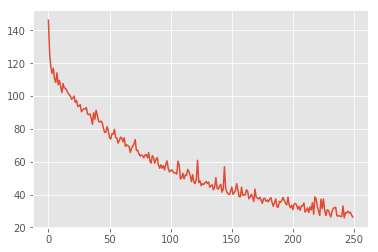

In [16]:
plt.plot(history.history['loss'])

In [17]:
trainPredict = model.predict(trainX_ok)
testPredict = model.predict(testX_ok)
simuPredict = model.predict(simuX_ok)
nextPredict = model.predict(testX_ok[-1:,:])

In [18]:
print(nextPredict,df_simu[0:1].values)

[[28.339956]] [[28.]]


In [19]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.47854227213116374

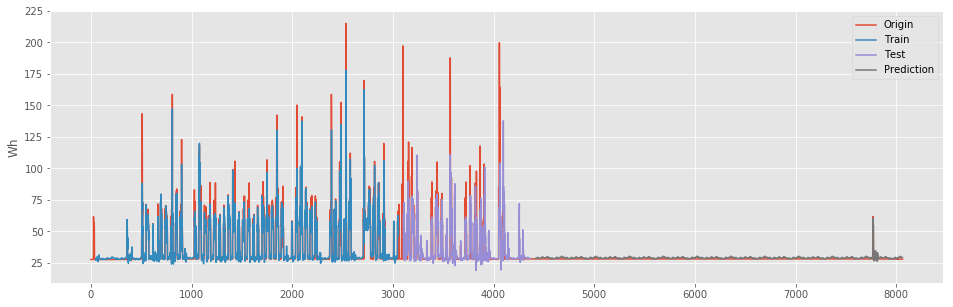

In [20]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [21]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

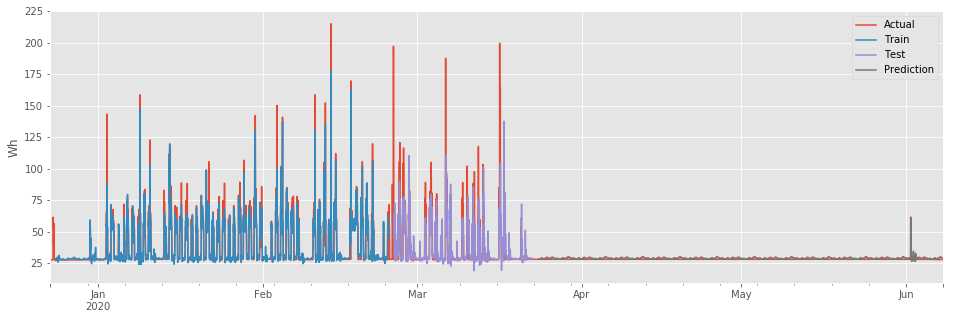

In [22]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

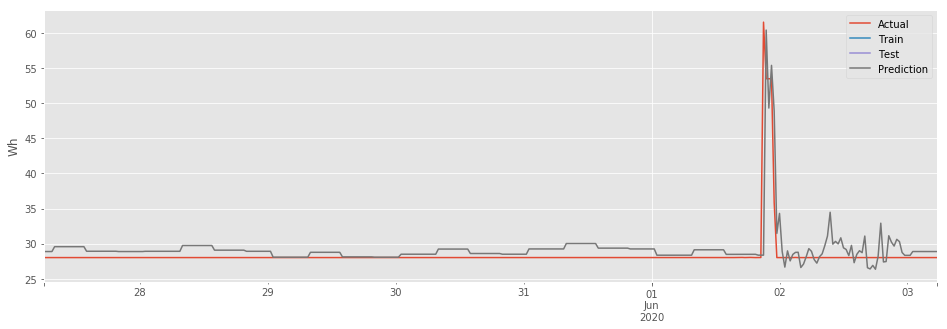

In [23]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

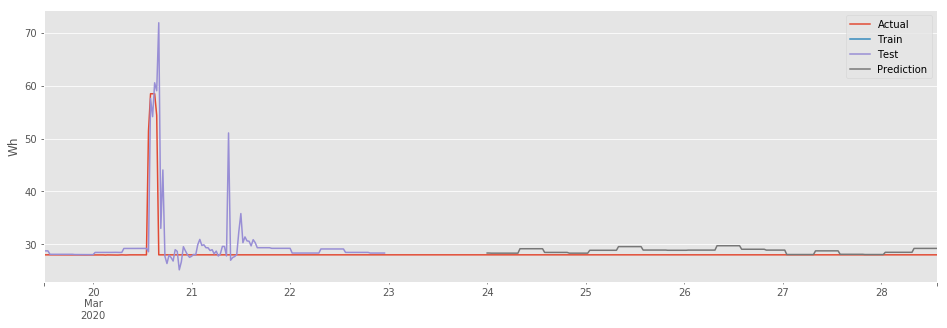

In [24]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

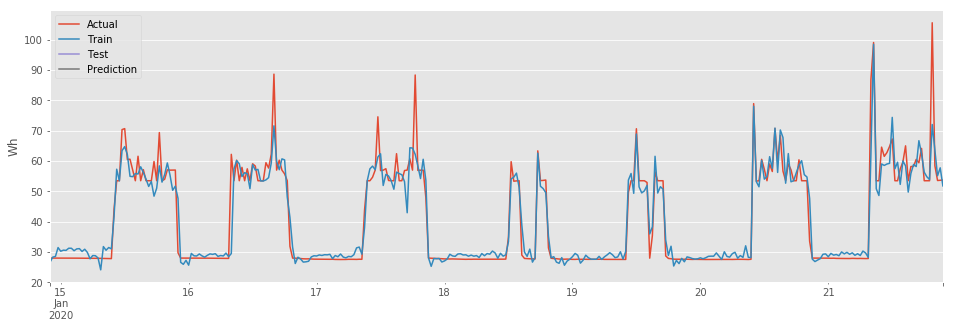

In [25]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [26]:
# save the model 
model.save('printer_nolock_ann.h5')

In [5]:
# with lockdown
mad_mean_ratio =5.41*1311/df_half['Half_Wh'][4368-1311:4368].sum() 
mad_mean_ratio

0.15046263315696465